# How to use:
This is an experimental semi-batch polymerization simulator to design the sequences of block-random-heteropolymers. In the "INPUT" block:
- set the number of uniqe monomers in your system (note: only tested for up to 5 unique monomers - small bugs may occur if you go over that)
- the initial molar feeding ratios (MRs)
- the reactivity ratios of monomers
- conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
- average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%
- the number of chains you wish to simulate (I recommend at least 15,000 for any kind of statistical analysis on the sequences for a sufficient sample population)
- the average length of the first block to simulate
- how polydisperse you want your batch of polymers to be (1 == no polydispersity, get closer and closer to 0 to get a wider spread of chain lengths)
- set if you have a minimum chain length to prune off any oligomers.
- block length

During simulation an input box under the "SIMULATE" cell will prompt you to keep inputting if you want to run the next block (type in anything other than "n") and if so, it will prompt you to input in the next set of MRs that you are "injecting into your semi-batch system" as well as the next block length you want to target to grow off of the previous block. Once you are done adding blocks enter "n" into the input prompt for next block.

The remaining codes are just for plotting and visualization taken from the main RHPapp.

Notes for future work:
(1) Let me know if you want me to build a direct API to pass in a series of preset sequences from an input text file or something like that.
(2) I think the initial setup could be optimized to be more clear with how "conv" and "avgDP" work.

In [1]:
# import simulator
from simulate import run_semi_batch

In [2]:
############################
######### INPUTS ###########
############################

# Number of unique monomers
N_MONs = 3

# Molar ratios of each monomer
# ex. if N_MONs = 4: [0.5, 0.25, 0.20, 0.05]
MRs = [0.33, 0.33, 0.33]

# reactivity ratios of monomers, ex. for 4 monomers:
#[r12, r13, r14]
#[r21, r23, r24]
#[r31, r32, r34]
#[r41, r42, r43]
#RRs = ([[1, 1, 1],
#        [1, 1.09, 1.09],
#        [1, 1.09, 1.09],
#        [1, 1.09, 1.09],])
RRs = ([[0.89, 1.35],
        [1.09, 0.69],
        [0.52, 0.91]])

# % conversion targetted (0-1), i.e. how much of the monomer pool do you want to use
conv = 1

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
avgDP = 100

# number of polymer chains to simulate
N_CHAINs = 10000

# average degree of polymerization (chain length) you are targetting at YOUR conversion, NOT at 100%.
BLOCK_LEN = 10

# Chain transfer % (0-1)
# TODO: replace this with direct PDI control
CTP = 1

# cutoff DP of chains considered as polymers not oligomers that get "purified" out
# set to 0 if you don't want to do any filtration
PRUNE_OLIGOMERS = 0

In [3]:
############################
######## SIMULATE ##########
############################

run_semi_batch(N_MONs, N_CHAINs, MRs, RRs, avgDP, conv, CTP, PRUNE_OLIGOMERS, BLOCK_LEN)

Initial monomer pool fraction: 1
Initial monomer pool MR: [0.33, 0.33, 0.33]
Now your remaining monomer pool MR is [0.33, 0.33, 0.34] and remaining monomer pool fraction is 0.89
Global conversion = 11.0 % of total monomer pool reacted
Current monomer amounts: 293413 297553 299033 
Polymerize next block? (y/n): y
Enter new monomer pool MR (feeding ratio) separated by a spaces: 0.8 0.1 0.1
In order to achieve this we need to add more monomer into the reactor as a molar ratio of the initial monomer pool. The following mole fractions of monomers are added [7.0, 0.0, 0.0] .
New monomer amounts: 2347304.0 297553.0 299033.0 
Enter next average block length:20
Polymerizing next block with MRs: [0.8, 0.1, 0.1] and average block length: 20
Initial monomer pool fraction: 0.89
Initial monomer pool MR: [0.8, 0.1, 0.1]
Now your remaining monomer pool MR is [0.8, 0.1, 0.1] and remaining monomer pool fraction is 2.74
Global conversion = 6.79 % of total monomer pool reacted
Current monomer amounts: 218

In [4]:
#importing packages for sequence analysis
import pandas as pd
import numpy as np
import glob, os
import csv
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import copy
import csv
from tqdm import tqdm_notebook
from itertools import tee
import re
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# this is important to allow us to save figs as editable .pdf
# 42 is some magic number encoded into matplotlib for True Font type
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none'}
matplotlib.rcParams.update(new_rc_params)

XUGROUP_IGOR_MACRO_SIZE = 22

plt.rc('font', family='Helvetica', size=XUGROUP_IGOR_MACRO_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=XUGROUP_IGOR_MACRO_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=XUGROUP_IGOR_MACRO_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XUGROUP_IGOR_MACRO_SIZE)    # legend fontsize
plt.rc('figure', titlesize=XUGROUP_IGOR_MACRO_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=10)
plt.rc('lines', linewidth=2) # thicker lines to match Xu Group Igor Macros

In [5]:
### IMPORT ALL SEQUENCE CSV FILES IN FOLDER SPECIFIED BY PATH

path = "outputs"
csv_files = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_files.append(os.path.join(path, file))
csv_files = sorted(csv_files)
print("Number of sequence files:", len(csv_files))
print(csv_files)

### SET MOLECULAR WEIGHTS OF MONOMERS IN ORDER OF LABEL (labels are 1 indexed)
Mw = [100.121,500,198.3,246.32, 104.15]
HLBs = [8.45, 11.42, 5.125, 18.5, 4.865]


Number of sequence files: 3
['outputs/NM3_MR[10, 80, 10]_NC10000_DP130_conv100_CTP100_FILT0.csv', 'outputs/NM3_MR[33, 33, 33]_NC10000_DP70_conv10000_CTP100_FILT0.csv', 'outputs/NM3_MR[80, 10, 10]_NC10000_DP110_conv100_CTP100_FILT0.csv']


In [6]:
### CALCULATE AVERAGE DP, Mn, Mw & PDI OF ALL SEQUENCES

names = []
num_seqs = []
avg_Mns = []
avg_Mws = []
PDIs = []
avg_DPs = []
seqs = []

for m in tqdm_notebook(range(len(csv_files))):
    seq = []

    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
    raw_seq = copy.deepcopy(seq)
    seqs.append(raw_seq)
    seqlen = np.zeros(i)
    seqweight = np.zeros(i)
    seqweight2 = np.zeros(i)

    for j in range(0,i):
        seqlen[j] = len(seq[j])
        for k in range(len(seq[j])):
            seq[j][k] = Mw[int(seq[j][k])-1]
        seqweight[j] = sum(seq[j])
        seqweight2[j] = (sum(seq[j])**2)
    
    # calculating molecular weight of chain (number-average or weight-average),
    # degree of polymerization (DP), and polydispersity index (PDI)
    AvgMw = sum(seqweight2)/sum(seqweight)
    AvgMn = sum(seqweight)/len(seqweight)
    PDI = AvgMw/AvgMn
    DP = sum(seqlen)/len(seqlen)
    
    # formatting general sequence statistics & average properties calculated as csv file
    names.append(csv_files[m].replace(path, '').replace('/', '').replace('.csv', ''))
    n_mons = []
    MR1s = []
    MR2s = []
    MR3s = []
    MR4s = []
    MR5s = []
    for name in names:
        try:
            # n_mons, MR1, ... MRN, n_chains, DP, conv, CTP, Filt
            num_vals = re.findall(r'\d+', name)
            n_mons.append(int(num_vals[0]))
            MR1s.append(int(num_vals[1]))
            MR2s.append(int(num_vals[2]))
            if len(num_vals) > 8:
                MR3s.append(int(num_vals[3]))
            else:
                MR3s.append(0)
            if len(num_vals) > 9:
                MR4s.append(int(num_vals[4]))
            else:
                MR4s.append(0)
            if len(num_vals) > 10:
                MR5s.append(int(num_vals[5]))
            else:
                MR5s.append(0)
        except IndexError as err:
            n_mons.append(4)
            MR1s.append(0)
            MR2s.append(0)
            MR3s.append(0)
            MR4s.append(0)
            MR5s.append(0)
    num_seqs.append(i)
    avg_Mns.append(AvgMn)
    avg_Mws.append(AvgMw)
    PDIs.append(PDI)
    avg_DPs.append(DP)
    
d = {'Batch Name': names, 'Mons': n_mons, 'MR1': MR1s, 'MR2': MR2s, 'MR3': MR3s, 'MR4': MR4s, 'MR5': MR5s, 'NC': num_seqs, 'Avg Mn': avg_Mns, 'Avg Mw': avg_Mws, 'PDI': PDIs, 'Avg DP': avg_DPs}
df_prop = pd.DataFrame(data=d)

#Read csv output files of 'n' batches and convert to n-element pd dataframe
dfs = []
seq_lens = []

for m in range(len(csv_files)):
    seq = []
    row_size = [] 
    
    with open(csv_files[m], mode = 'r') as file:
        csvFile = csv.reader(file)
        i = 0
        for lines in csvFile:
            i = i + 1
            seq.append(lines)
            row_size.append(len(lines))
        df = pd.DataFrame(seq)
        dfs.append(df)
        seq_lens.append(row_size)

df_prop

/var/folders/rv/54f9k4tj70j46wh3k1hvhlfc0000gn/T/ipykernel_90358/655882240.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm_notebook(range(len(csv_files))):


  0%|          | 0/3 [00:00<?, ?it/s]

,Batch Name,Mons,MR1,MR2,MR3,MR4,MR5,NC,Avg Mn,Avg Mw,PDI,Avg DP
0,"NM3_MR[10, 80, 10]_NC10000_DP130_conv100_CTP10...",3,10,80,10,0,0,10000,10137.255181,10508.590740,1.036631,41.0
1,"NM3_MR[33, 33, 33]_NC10000_DP70_conv10000_CTP1...",3,33,33,33,0,0,10000,18634.093001,18990.888053,1.019147,71.0
2,"NM3_MR[80, 10, 10]_NC10000_DP110_conv100_CTP10...",3,80,10,10,0,0,10000,4384.677119,4692.438336,1.070190,21.0


<Figure size 432x288 with 0 Axes>

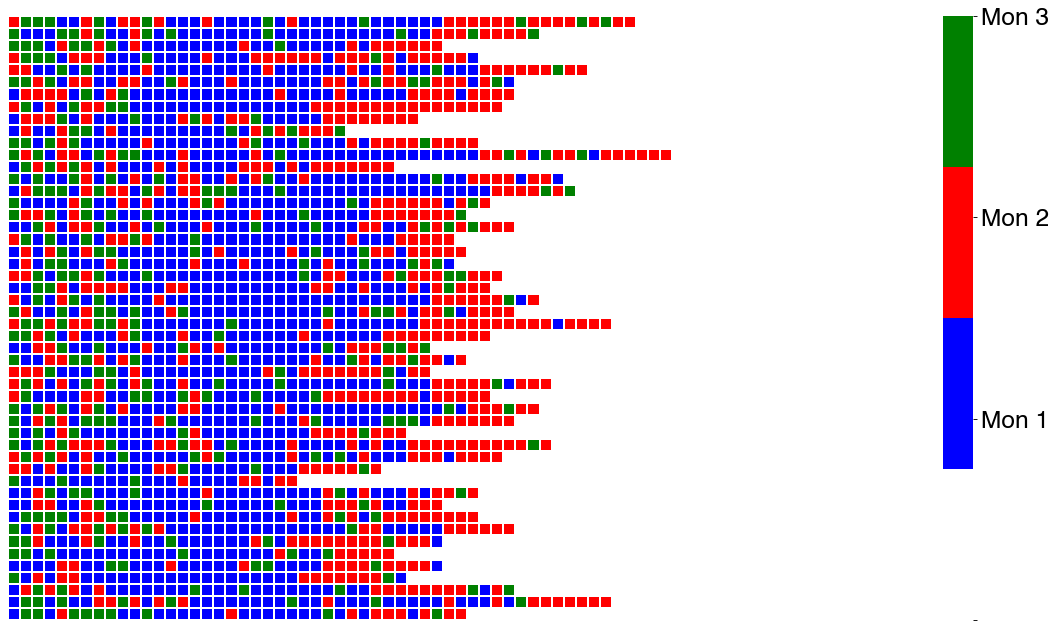

<Figure size 432x288 with 0 Axes>

In [9]:
### VISUALIZE SEQUENCE SIMULATED
import matplotlib.colors as colors

batch_no = 0
seq_no = 0
num_seqs = 50

chains = []
for i in range(num_seqs):
    chains.append([int(x) if x != None else 0 for x in dfs[batch_no].iloc[seq_no + i]])

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.figure(num=None, figsize=(25, 10), dpi=80, facecolor='w', edgecolor='k')
CMAP = ['white','blue','red','green','yellow','pink']
ax = sns.heatmap(chains, vmin=0, vmax=df_prop.iloc[batch_no]['Mons'], linewidth=0.2, xticklabels=False, yticklabels=False, square=True, cmap=CMAP[:(N_MONs+1)])
cb = ax.collections[0].colorbar
cb.set_ticks(np.arange(N_MONs+1))
cb.set_ticklabels(['', 'Mon 1', 'Mon 2', 'Mon 3', 'Mon 4', 'Mon 5'][:N_MONs+1])

plt.show()
plt.cla()   # Clear axis
plt.clf()   # Clear figure
